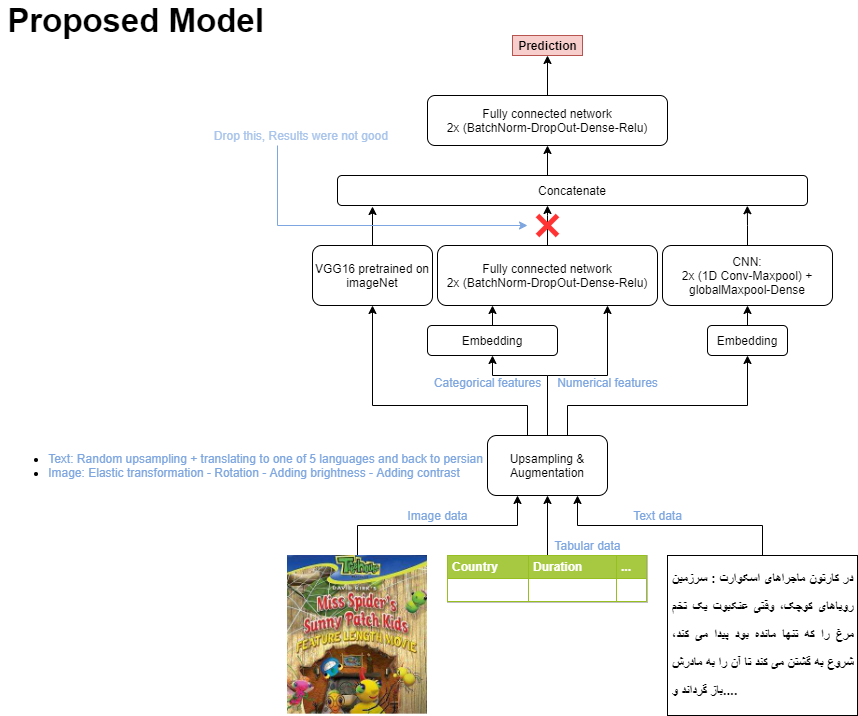

## PLEASE READ THIS FIRST

In the last part, Predicting Test dataset, a CSV file (Results.CSV) is created containing the predicted label names by the same order of the evaluation dataset CSV file provided. In order to evaluate my model's performance (Accuracy, F1, ... ) on test dataset, please use Results.CSV File provided.

## Import libraries and mount google drive

In [1]:
# pip install hazm

import random
import codecs
from hazm import *
import os
import functools
from datetime import datetime

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline         

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from scipy.ndimage import gaussian_filter, map_coordinates, rotate
from skimage.transform import resize

import tensorflow as tf
import keras 
from keras import optimizers
from tensorflow.keras import Model, optimizers, utils
from keras.models import Sequential, load_model
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Dropout, BatchNormalization
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install hazm

     |████████████████████████████████| 317kB 7.1MB/s 
     |████████████████████████████████| 235kB 10.8MB/s 
     |████████████████████████████████| 1.4MB 13.8MB/s 
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154483 sha256=43fd7f7ec3e76244f382b71bf5c15fee26325e661ad98b3751f29692a5cb5844
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394470 sha256=341b662fd02fcb5764f12fb2e100de89fbf4e7201abebe4c144f480f198099e7
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built libwapiti nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## Read Train and Test datasets

### Train dataset

In [33]:
df = pd.read_csv('./drive/MyDrive/Bazzar/train_set.csv')
df

,video_id,title_fa,description_fa,age_rating,country_fa,production_year,duration,genre,image
0,_WuOoL_filimo,نیش,همسر و فرزند خردسال یك سروان نیروی انتظامی، كه...,0.0,ایران,1994.0,01:27:22,action,videos_covers_066f34bc-aaeb-4c74-a78c-83f0250c...
1,yIaxeg8x,سرگذشت حقیقی دار و دسته کلی,درباره فیلم سرگذشت حقیقی دار و دسته کلی فیلم ...,,انگلستان,2020.0,01:46:00,drama,videos_covers_c36937ab-5b60-44f0-8152-01bc6ae6...
2,King_Arthur-Legend_of_the_Sword_4d6P2_filimo,شاه آرتور - افسانه شمشیر,آرتور، مرد جوانی است که در دوران کودکی دزدیده ...,0.0,آمریکا,2017.0,02:04:29,action,videos_covers_128fef8c-2a5a-417e-9061-7d06864f...
3,TJAkVhmb,تارزان و جین,انیمیشن تارزان و جین به ماجرای تارزان و آشنایی...,7.0,آمریکا,2017.0,,adventure,videos_covers_f0b8492b-5e94-4cc4-9bec-dcf93e08...
4,Life_Cycles_0ym29_filimo,چرخ عمر,مستند چرخ عمر داستانی در مورد یک دوچرخه کوهستا...,13.0,کانادا,2010.0,00:46:58,documentary,videos_covers_965f947c-ee7d-4851-9fa5-ba303524...
...,...,...,...,...,...,...,...,...,...
10995,_omrwa_filimo,می خواهم زنده بمانم,اصلان و ماه منیر به خاطر اختلافات طلاق میگیر...,13.0,ایران,1994.0,01:47:06,family,videos_covers_ff8d33fb-7de2-453d-8fad-333affbd...
10996,Momentum_3y5bP_filimo,مقدار حرکت,در فیلم مقدار حرکت، هنگامی که یک دزد مرموز توس...,17.0,آفریقای جنوبی,2015.0,01:35:34,thriller,videos_covers_98ffbfe4-affa-456e-82cd-7251e80c...
10997,U8vw2P8R,گناهکار ذاتی,فیلم گناهکار ذاتی به کارگردانی سویی کوآن لی و ...,17.0,هنگ کنگ,2019.0,01:31:20,action,videos_covers_4de8ba64-339e-43dd-996b-4379a101...
10998,L_aveu_7YxLp_filimo,اعتراف,در چکسلواکی کمونیست ۱۹۵۰ یک وزیر و یک قهرمان ...,17.0,فرانسه,1970.0,01:56:16,social,videos_covers_7e88e403-b2fb-4560-b346-055433a6...


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   video_id         11000 non-null  object
 1   title_fa         11000 non-null  object
 2   description_fa   8559 non-null   object
 3   age_rating       11000 non-null  object
 4   country_fa       10882 non-null  object
 5   production_year  11000 non-null  object
 6   duration         11000 non-null  object
 7   genre            11000 non-null  object
 8   image            11000 non-null  object
dtypes: object(9)
memory usage: 773.6+ KB


### Test Dataset

In [81]:
df_test = pd.read_csv('./drive/MyDrive/Bazzar/eval_set.csv')
df_test

,video_id,title_fa,description_fa,age_rating,country_fa,production_year,duration,image
0,E0yLLCIp,دونده هزارتو,NaN,,آمریکا,2014.0,01:54:00,videos_covers_921fbbc1-0d58-4378-8e5b-92193edf...
1,wCFnNqf6,ماجراهای اسکوارت,در کارتون ماجراهای اسکوارت : سرزمین رویاهای کو...,7.0,کانادا,2003.0,00:49:01,videos_covers_f27599fe-0d9a-47ce-b796-997b2429...
2,2gZF76hm,خانم یایا,عبدالرضا کاهانی نویسنده و کارگردان زاده ۱ دی ۱...,13.0,ایران,2019.0,01:19:15,videos_covers_589607ad-e02f-443f-91f7-ac6c2388...
3,HrSbo_Fullmetal_Alchemist_E_filimo_series,کیمیاگر تمام فلزی,بعد از یک آزمایش شکست خورده کیمیاگری برای زند...,7.0,ژاپن,2003.0,,videos_covers_08cff5a5-0b18-4df5-ac8d-02744a74...
4,Bring_Me_the_Head_of_Alfredo_Garcia_5txA1_filimo,سر آلفردو گارسیا را برایم بیاورید,فیلم سر آلفردو گارسیا را برایم بیاورید اثر کمت...,17.0,آمریکا,1974.0,01:17:11,videos_covers_393f9008-f5fd-43cc-b222-4b28c060...
...,...,...,...,...,...,...,...,...
1549,_1glWy_filimo,خونرنگ,مستند خونرنگ به توصیف و بررسی و تحلیل جنگ رسان...,13.0,ایران,2016.0,00:18:08,videos_covers_c469ba76-c88f-49ce-b054-bdf53677...
1550,EBlocLkU,دوزیست,«دوزیست»، فیلمی در ژانر اجتماعی به کارگردانی «...,17.0,ایران,2010.0,01:24:10,videos_covers_b25ebc2d-a6ff-41d1-8c83-1779d463...
1551,_6RaQ3_filimo,جهنم سبز,آقای حیدری كه شكاربان سالخورده منطقه جنگلی حفا...,0.0,ایران,1995.0,01:31:51,videos_covers_f920bf5f-c8e8-4e8e-9863-d60ca7ff...
1552,a57zspMm,داستان اسباب‌ بازی,NaN,,آمریکا,1995.0,01:21:00,videos_covers_5cc512fd-dee3-4001-b25c-822f925e...


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   video_id         1554 non-null   object 
 1   title_fa         1554 non-null   object 
 2   description_fa   1215 non-null   object 
 3   age_rating       1554 non-null   object 
 4   country_fa       1542 non-null   object 
 5   production_year  1554 non-null   float64
 6   duration         1554 non-null   object 
 7   image            1554 non-null   object 
dtypes: float64(1), object(7)
memory usage: 97.2+ KB


In [96]:
df_test.loc[1].image

'videos_covers_f27599fe-0d9a-47ce-b796-997b242954fe.jpg'

# Dataset cleaning

All columns are casted to their original types and empty values are replaced by nan

### Train

In [37]:
df = pd.read_csv('./drive/MyDrive/Bazzar/train_set.csv') 
df = df.drop(columns=['video_id'])

# INT or CONTINUOUS NAN VALUES

# Cast year to int and nan the bulshits
df.loc[df['production_year'] == ' ', 'production_year'] = np.nan
df.loc[df['production_year'] == '0.0', 'production_year'] = np.nan
df['production_year'] = pd.to_numeric(df['production_year'], downcast='integer')

#Change duration to time
df.loc[df['duration'] == ' ', 'duration'] = np.nan
df['duration'] = pd.to_datetime(df['duration'],format= '%H:%M:%S' ).dt.time 
#Change time to seconds
df['duration'] = [t.hour * 3600 + t.minute * 60 + t.second for t in df['duration']]
df.loc[df['duration'] == 0, ['duration']] = np.nan

# Clean age ratings and cast to int
df.loc[df['age_rating'] == ' ', 'age_rating'] = np.nan
df.loc[df['age_rating'] == '0.0' , 'age_rating'] = np.nan
df['age_rating'] = pd.to_numeric(df['age_rating'], downcast='integer')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title_fa         11000 non-null  object 
 1   description_fa   8559 non-null   object 
 2   age_rating       6889 non-null   float64
 3   country_fa       10882 non-null  object 
 4   production_year  10966 non-null  float64
 5   duration         10126 non-null  float64
 6   genre            11000 non-null  object 
 7   image            11000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 687.6+ KB


Nan values for the nominal columns are filled by Mice imputation

In [38]:
#MICE Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
tmp = imp.fit_transform(df[['age_rating','production_year','duration']])
tmp = pd.DataFrame(tmp, columns=['age_rating','production_year','duration'])

df['age_rating'] = tmp['age_rating'].astype(int)
df['production_year'] = tmp['production_year'].astype(int)
df['duration'] = tmp['duration'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title_fa         11000 non-null  object
 1   description_fa   8559 non-null   object
 2   age_rating       11000 non-null  int64 
 3   country_fa       10882 non-null  object
 4   production_year  11000 non-null  int64 
 5   duration         11000 non-null  int64 
 6   genre            11000 non-null  object
 7   image            11000 non-null  object
dtypes: int64(3), object(5)
memory usage: 687.6+ KB


In [39]:
df.head()

,title_fa,description_fa,age_rating,country_fa,production_year,duration,genre,image
0,نیش,همسر و فرزند خردسال یك سروان نیروی انتظامی، كه...,13,ایران,1994,5242,action,videos_covers_066f34bc-aaeb-4c74-a78c-83f0250c...
1,سرگذشت حقیقی دار و دسته کلی,درباره فیلم سرگذشت حقیقی دار و دسته کلی فیلم ...,14,انگلستان,2020,6360,drama,videos_covers_c36937ab-5b60-44f0-8152-01bc6ae6...
2,شاه آرتور - افسانه شمشیر,آرتور، مرد جوانی است که در دوران کودکی دزدیده ...,15,آمریکا,2017,7469,action,videos_covers_128fef8c-2a5a-417e-9061-7d06864f...
3,تارزان و جین,انیمیشن تارزان و جین به ماجرای تارزان و آشنایی...,7,آمریکا,2017,3920,adventure,videos_covers_f0b8492b-5e94-4cc4-9bec-dcf93e08...
4,چرخ عمر,مستند چرخ عمر داستانی در مورد یک دوچرخه کوهستا...,13,کانادا,2010,2818,documentary,videos_covers_965f947c-ee7d-4851-9fa5-ba303524...


### Test

In [40]:
df_test = pd.read_csv('./drive/MyDrive/Bazzar/eval_set.csv') 
df_test = df_test.drop(columns=['video_id'])

# INT or CONTINUOUS NAN VALUES

# Cast year to int and nan the bulshits (Its float this time)
df_test.loc[df_test['production_year'] == 0.0, 'production_year'] = np.nan
df_test.loc[df_test['production_year'] == " ", 'production_year'] = np.nan
df_test['production_year'] = pd.to_numeric(df_test['production_year'], downcast='integer')

#Change duration to time
df_test.loc[df_test['duration'] == ' ', 'duration'] = np.nan
df_test['duration'] = pd.to_datetime(df_test['duration'],format= '%H:%M:%S' ).dt.time 
#Change time to seconds
df_test['duration'] = [t.hour * 3600 + t.minute * 60 + t.second for t in df_test['duration']]
df_test.loc[df_test['duration'] == 0, ['duration']] = np.nan

# Clean age ratings and cast to int
df_test.loc[df_test['age_rating'] == " ", 'age_rating'] = np.nan
df_test.loc[df_test['age_rating'] == '0.0' , 'age_rating'] = np.nan
df_test['age_rating'] = pd.to_numeric(df_test['age_rating'], downcast='integer')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title_fa         1554 non-null   object 
 1   description_fa   1215 non-null   object 
 2   age_rating       978 non-null    float64
 3   country_fa       1542 non-null   object 
 4   production_year  1544 non-null   float64
 5   duration         1419 non-null   float64
 6   image            1554 non-null   object 
dtypes: float64(3), object(4)
memory usage: 85.1+ KB


In [41]:
#MICE Imputation

# ONLY TRANSFORM THIS TIME!!!
tmp = imp.transform(df_test[['age_rating','production_year','duration']])
tmp = pd.DataFrame(tmp, columns=['age_rating','production_year','duration'])

df_test['age_rating'] = tmp['age_rating'].astype(int)
df_test['production_year'] = tmp['production_year'].astype(int)
df_test['duration'] = tmp['duration'].astype(int)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title_fa         1554 non-null   object
 1   description_fa   1215 non-null   object
 2   age_rating       1554 non-null   int64 
 3   country_fa       1542 non-null   object
 4   production_year  1554 non-null   int64 
 5   duration         1554 non-null   int64 
 6   image            1554 non-null   object
dtypes: int64(3), object(4)
memory usage: 85.1+ KB


### Outliers in Production year

We see in our training set some of the dates are from the sun calendar and some from the moon

This is fixed, but other logical outliers are left untouched in test set

1359       2
1360       1
1362       1
1364       4
1365       8
        ... 
2016     575
2017     687
2018     984
2019    1066
2020     494
Name: production_year, Length: 144, dtype: int64

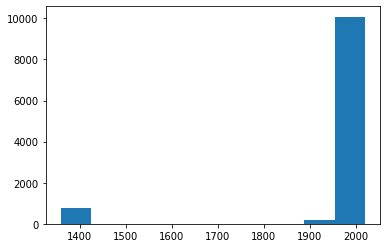

In [42]:
plt.hist(df.production_year)
df.production_year.value_counts().sort_index()

##### Change sun calendar to moon calendar in train and test

In [43]:
df.loc[df['production_year'] < 1500, 'production_year'] += (2020 - 1399)
df_test.loc[df_test['production_year'] < 1500, 'production_year'] += (2020 - 1399)

df.production_year.value_counts().sort_index()

1697       1
1914       2
1916       1
1917       1
1919       2
        ... 
2016     629
2017     763
2018    1085
2019    1090
2020     500
Name: production_year, Length: 105, dtype: int64

In [44]:
#Fix 1697!!!
df[df['production_year'] == 1697]['description_fa'].to_numpy()

array(['«رکسیو» انیمیشنی محصول کشور لهستان که در سالهای 1960 تا 1990 پخش شد. شخصیت اصلی این انیمیشن سگی به نام رکسیو بود که در هر قسمت ماجرایی از او و دوستانش روایت می شود.'],
      dtype=object)

In [45]:
df.loc[df['production_year'] == 1697, 'production_year'] = 1960

### Duration is ok

55       1
59       1
64       1
69       1
73       1
        ..
13620    1
13755    1
13920    1
14160    1
28800    3
Name: duration, Length: 3939, dtype: int64

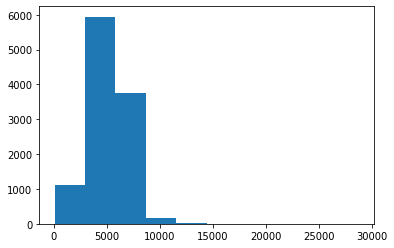

In [46]:
plt.hist(df.duration)
df.duration.value_counts().sort_index()

### Description 
replace nan types by empty strings, and merge title_fa column into description to avoid empty values

##### Train

In [47]:
# change nan in description to ''
df.loc[df['description_fa'].isna(), 'description_fa'] = ''
# Combine title and description
df['description_fa'] = df[['title_fa', 'description_fa']].agg(' '.join, axis=1)
#Remove title column
df = df.drop(columns=['title_fa'])

##### Test

In [48]:
df_test.loc[df_test['description_fa'].isna(), 'description_fa'] = ''
df_test['description_fa'] = df_test[['title_fa', 'description_fa']].agg(' '.join, axis=1)
df_test = df_test.drop(columns=['title_fa'])

### Cleaning Country and further cleaning on Description
##### Train and test

In [49]:
# CATEGORICAL NAN VALUES

# First, lets fill empty country with '-' which is the default value for no country in the dataset itself!

#Train
df.loc[df['country_fa'].isna(), 'country_fa'] = '-'
#Test
df_test.loc[df_test['country_fa'].isna(), 'country_fa'] = '-'

#From most important to least important
country_list = np.sort(df.country_fa.value_counts().index)
country_list

array(['-', 'آرژانتین', 'آفریقای جنوبی', 'آفریقای جنوبی    ',
       'آفریقای شمالی', 'آلمان', 'آلمان    ', 'آمریکا', 'آمریکا    ',
       'اتریش', 'اتریش    ', 'استرالیا', 'استرالیا    ', 'اسپانیا',
       'اسپانیا    ', 'افغانستان', 'امارات متحده عربی',
       'امارات متحده عربی ', 'اندونزی', 'اندونزی    ', 'انگلستان',
       'انگلستان    ', 'انگلیس', 'اوکراین', 'ایالات متحده آمریکا',
       'ایتالیا', 'ایتالیا    ', 'ایران', 'ایرلند', 'ایرلند    ',
       'ایسلند', 'ایسلند    ', 'برزیل', 'بلژیک', 'بلژیک    ', 'تایلند',
       'تایلند    ', 'تایوان', 'ترکیه', 'جمهوری چک', 'جمهوری چک    ',
       'دانمارک', 'دانمارک    ', 'روسیه', 'روسیه    ', 'سنگاپور', 'سوئد',
       'سوئد    ', 'سوییس', 'شیلی', 'غیره', 'فرانسه', 'فرانسه    ',
       'فنلاند', 'فنلاند    ', 'فیلیپین', 'لبنان', 'لهستان', 'لهستان    ',
       'لوکزامبورگ', 'مالزی', 'مالزی    ', 'مجارستان    ', 'مقدونیه',
       'مکزیک', 'مکزیک    ', 'نروژ', 'نیوزلند', 'نیوزلند    ', 'هلند',
       'هلند    ', 'هند', 'هند    ', 'هنگ کن

In [50]:
#Make all characters persian in country and description
def regularize_unicode(s):
    s=s.replace('ك', 'ک')
    s=s.replace('ي', 'ی')
    # Half space
    s=s.replace(chr(8204), '')

#Strip redundant spaces then regularize

#train
df.country_fa = df.country_fa.str.lstrip()
df.country_fa = df.country_fa.str.rstrip()
df.country_fa.apply(lambda x: regularize_unicode(x))
df.description_fa.apply(lambda x: regularize_unicode(x))

#test
df_test.country_fa = df_test.country_fa.str.lstrip()
df_test.country_fa = df_test.country_fa.str.rstrip()
df_test.country_fa.apply(lambda x: regularize_unicode(x))
df_test.description_fa.apply(lambda x: regularize_unicode(x))

country_list = np.sort(df.country_fa.value_counts().index)
country_list

array(['-', 'آرژانتین', 'آفریقای جنوبی', 'آفریقای شمالی', 'آلمان',
       'آمریکا', 'اتریش', 'استرالیا', 'اسپانیا', 'افغانستان',
       'امارات متحده عربی', 'اندونزی', 'انگلستان', 'انگلیس', 'اوکراین',
       'ایالات متحده آمریکا', 'ایتالیا', 'ایران', 'ایرلند', 'ایسلند',
       'برزیل', 'بلژیک', 'تایلند', 'تایوان', 'ترکیه', 'جمهوری چک',
       'دانمارک', 'روسیه', 'سنگاپور', 'سوئد', 'سوییس', 'شیلی', 'غیره',
       'فرانسه', 'فنلاند', 'فیلیپین', 'لبنان', 'لهستان', 'لوکزامبورگ',
       'مالزی', 'مجارستان', 'مقدونیه', 'مکزیک', 'نروژ', 'نیوزلند', 'هلند',
       'هند', 'هنگ کنگ', 'ویتنام', 'پرو', 'چکسلواکی', 'چین', 'ژاپن',
       'کانادا', 'کره جنوبی'], dtype=object)

In [51]:
# When we see some country names in the description and the country field is empty, we put that country in the country column
# When there is no country info anywhere we put the country in the column that is dominant in our dataset! (AMERICA!!)

#Train:
print('number of empty countries before :', len(df[df.country_fa == '-']))

tmpdf = df[df.country_fa == '-']
for country in country_list:
    s = tmpdf.description_fa.str.contains(country)
    df.loc[tmpdf.description_fa.str.contains(country).index, 'country_fa'] = country
    
print('number of empty countries after :', len(df[df.country_fa == '-']))

#Correct the duplicates
df.loc[df['country_fa'] == 'ایالات متحده آمریکا', 'country_fa'] =  'آمریکا'
df.loc[df['country_fa'] == 'چکسلواکی'  , 'country_fa'] = 'جمهوری چک'
df.loc[df['country_fa'] == 'انگلستان'  , 'country_fa'] = 'انگلیس'

#Replace remaining empty countries with maximum accuring country (America)
df.loc[df['country_fa'] == '-', 'country_fa'] = df['country_fa'].value_counts().idxmax()

print('number of empty countries aftest!! :', len(df[df.country_fa == '-']))


#Test
country_list = np.sort(df_test.country_fa.value_counts().index)
tmpdf = df_test[df_test.country_fa == '-']
for country in country_list:
    s = tmpdf.description_fa.str.contains(country)
    df_test.loc[tmpdf.description_fa.str.contains(country).index, 'country_fa'] = country
df_test.loc[df_test['country_fa'] == 'ایالات متحده آمریکا', 'country_fa'] =  'آمریکا'
df_test.loc[df_test['country_fa'] == 'چکسلواکی'  , 'country_fa'] = 'جمهوری چک'
df_test.loc[df_test['country_fa'] == 'انگلستان'  , 'country_fa'] = 'انگلیس'
df.loc[df['country_fa'] == '-', 'country_fa'] = df['country_fa'].value_counts().idxmax()

number of empty countries before : 128
number of empty countries after : 0
number of empty countries aftest!! : 0


There is a country in test which is not present in training!!!! lets find it and set it to 'غیره'

In [52]:
mask = np.in1d(np.sort(df_test.country_fa.value_counts().index), np.sort(df.country_fa.value_counts().index))
print(np.where(~mask)[0])

[23]


In [53]:
np.sort(df_test.country_fa.value_counts().index)[23]

'لیتوانی'

In [54]:
df_test.loc[df_test.country_fa == 'لیتوانی', 'country_fa'] = 'غیره'

# Visualization

### Pairplot of tabular data

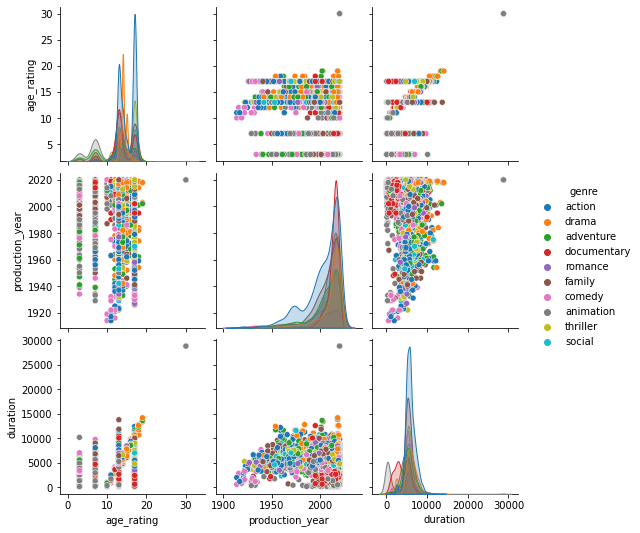

In [55]:
sns.pairplot(df[['age_rating', 'country_fa', 'production_year', 'duration', 'genre']], hue='genre', height=2.5) 
plt.show()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   description_fa   11000 non-null  object
 1   age_rating       11000 non-null  int64 
 2   country_fa       11000 non-null  object
 3   production_year  11000 non-null  int64 
 4   duration         11000 non-null  int64 
 5   genre            11000 non-null  object
 6   image            11000 non-null  object
dtypes: int64(3), object(4)
memory usage: 601.7+ KB


# Preprocessing

### Standardize tabular data

Genre is passed through a label encoder and contains numbers 0-9 

Country is passed through a label encoder too, but it is embedded in later steps before being fed to the model

The nominal features are passed through a standard scaler

In [57]:
X = df.copy()
X_test = df_test.copy()

In [58]:
categorical_features = 'country_fa'
numeric_features = ['age_rating','production_year','duration'] 
label = 'genre'

#Train
#categorical_transformer = OneHotEncoder()
categorical_transformer = LabelEncoder()
X[categorical_features] = categorical_transformer.fit_transform(X[categorical_features])

numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])
X[numeric_features] = preprocessor.fit_transform(X[numeric_features])

label_transformer = LabelEncoder()
X[label] = label_transformer.fit_transform(X[label])


#Test (Only transform)
X_test[categorical_features] = categorical_transformer.transform(X_test[categorical_features])
X_test[numeric_features] = preprocessor.transform(X_test[numeric_features])


X.shape
X

,description_fa,age_rating,country_fa,production_year,duration,genre,image
0,نیش همسر و فرزند خردسال یك سروان نیروی انتظامی...,-0.190627,14,-0.812003,0.007666,0,videos_covers_066f34bc-aaeb-4c74-a78c-83f0250c...
1,سرگذشت حقیقی دار و دسته کلی درباره فیلم سرگذشت...,0.108119,11,0.839971,0.636486,5,videos_covers_c36937ab-5b60-44f0-8152-01bc6ae6...
2,شاه آرتور - افسانه شمشیر آرتور، مرد جوانی است ...,0.406865,4,0.649359,1.260244,0,videos_covers_128fef8c-2a5a-417e-9061-7d06864f...
3,تارزان و جین انیمیشن تارزان و جین به ماجرای تا...,-1.983105,4,0.649359,-0.735894,1,videos_covers_f0b8492b-5e94-4cc4-9bec-dcf93e08...
4,چرخ عمر مستند چرخ عمر داستانی در مورد یک دوچرخ...,-0.190627,49,0.204596,-1.355715,4,videos_covers_965f947c-ee7d-4851-9fa5-ba303524...
...,...,...,...,...,...,...,...
10995,می خواهم زنده بمانم اصلان و ماه منیر به خاطر...,-0.190627,14,-0.812003,0.673608,6,videos_covers_ff8d33fb-7de2-453d-8fad-333affbd...
10996,مقدار حرکت در فیلم مقدار حرکت، هنگامی که یک دز...,1.004358,1,0.522284,0.284392,9,videos_covers_98ffbfe4-affa-456e-82cd-7251e80c...
10997,گناهکار ذاتی فیلم گناهکار ذاتی به کارگردانی سو...,1.004358,44,0.776434,0.141529,0,videos_covers_4de8ba64-339e-43dd-996b-4379a101...
10998,اعتراف در چکسلواکی کمونیست ۱۹۵۰ یک وزیر و یک ...,1.004358,30,-2.336903,0.982956,8,videos_covers_7e88e403-b2fb-4560-b346-055433a6...


### Fix class imbalance in training data

Random over sampler is used.

Using SMOTENC would yield better results, but because of the nature of this project (Containing image and description), SMOTENC cannot be used on all of the data, eventhough we need all the data's together for training...

Size of new dataset is over double of the old imbalanced dataset

In [ ]:
#Class imbalance 
categorical_features = ['country_fa']

# Random oversampling (For text and image, later these oversampled features are further processed.
# image duplicates are augmented and text duplicates are translated to another language and back! :D )

ovrsmpl = RandomOverSampler(sampling_strategy='not majority')
X, Y = ovrsmpl.fit_resample(X.drop(columns=['genre']), X.genre)

# SMOTENC oversampling for tabular data training
#ovrsmpl = SMOTENC(categorical_features=['country_fa'])
#X_SMOTENC, Y_SMOTENC = ovrsmpl.fit_resample(X.drop(columns=['genre', 'description_fa', 'image']), X.genre)


# Y from label to categorical
Y  = utils.to_categorical(Y)

X.shape, Y.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((23530, 6), (23530, 10))

# Training

For each datatype(Image, Tabular, Text), an independent and unique model is first trained and their weights are saved

### Tabular model

#### Model creation

Country (as a categorical datatype) is first embedded, then with the other nominal datas passed through a fully connected dense network

In [ ]:
# define the neural networks

tabular_inputs = []
embeddings = []

#Embedding :) 
# X[2] = X[country]
num_country_classes = X[:, 2].max() + 1
embedding_size =  int(min(600,round(1.6*num_country_classes**0.56)))

#embedding_size = 3

emb_dict = Input(shape=(1,), name='cat_input')
embedding = Embedding(input_dim = num_country_classes, output_dim = embedding_size, input_length = 1, name='cat_emb')(emb_dict)
embedding = Reshape(target_shape=(embedding_size,))(embedding)
tabular_inputs.append(emb_dict)
embeddings.append(embedding)

# concat continuous variables with embedded variables
cont_vars = ['age_rating','production_year','duration'] 
cont_input = Input(shape=(len(cont_vars),), name='cont_input')
embedding = BatchNormalization(name='cont_first_batch')(cont_input)
tabular_inputs.append(cont_input)
embeddings.append(embedding)
x = Concatenate(name='concat_2')(embeddings)

layers = [100]

# add fully-connected layers separated with batchnorm and dropout layers
for i in range(len(layers)):
    if i == 0:
        x = Dense(layers[i],activation="relu")(x)
    else:
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(layers[i],activation="relu")(x)

output = Dense(len(df.genre.unique()),activation="softmax")(x)
tabular_model = Model(tabular_inputs,output)
tabular_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_emb (Embedding)             (None, 1, 14)        714         cat_input[0][0]                  
__________________________________________________________________________________________________
cont_input (InputLayer)         [(None, 3)]          0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 14)           0           cat_emb[0][0]                    
______________________________________________________________________________________________

In [ ]:
#Input and output shapes
np.shape(tabular_inputs[0]), np.shape(tabular_inputs[1]), np.shape(output)

(TensorShape([None, 1]), TensorShape([None, 3]), TensorShape([None, 10]))

#### Compile model

Top 3 accuracy and categorical accuracy is used for model evaluation

In [ ]:
# Set K = 3 in top k categorical accuracy
top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

# Set learning rate
tabular_lr = 0.00001

# Compile model
tabular_opt = optimizers.Adam(tabular_lr)
tabular_model.compile(tabular_opt,  'categorical_crossentropy', [categorical_accuracy, top3_acc])

#### Prepare inputs and outputs

In [ ]:
#'description_fa', 'age_rating',	'country_fa',	'production_year', 	'duration',	'image'
cont_vars = [1, 3, 4] 
cat_vars  = [2]

tabular_input_list = []
tabular_input_list.append(X[:, cat_vars].astype(float))
tabular_input_list.append(X[: ,cont_vars].astype(float))

Y_tabular = Y
np.shape(tabular_input_list[0]), np.shape(tabular_input_list[1])

((23530, 1), (23530, 3))

#### Train!!!

Checkpoints are used to save model weights and structure (We need it for the final fused model) 

Learning rate is reduced on plateau

Early stopping is used

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

tabular_checkpoint = ModelCheckpoint(filepath='./drive/MyDrive/Bazzar/tabular_model.h5', 
                            verbose=1, save_best_only=True) #Save the whole model

early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True
)

callback = [tabular_checkpoint, lr_reducer, early_stopping_cb]

start = datetime.now()

tabular_history = tabular_model.fit(tabular_input_list, Y_tabular, epochs = 100, batch_size=128,  
                                    validation_split=0.2, callbacks = callback, shuffle=True)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
148/148 [==============================] - 3s 6ms/step - loss: 2.3050 - categorical_accuracy: 0.0801 - top3_acc: 0.2963 - val_loss: 2.3629 - val_categorical_accuracy: 0.0640 - val_top3_acc: 0.1528

Epoch 00001: val_loss improved from inf to 2.36292, saving model to ./drive/MyDrive/Bazzar/tabular_model.h5
Epoch 2/100
148/148 [==============================] - 1s 4ms/step - loss: 2.2921 - categorical_accuracy: 0.0829 - top3_acc: 0.3024 - val_loss: 2.3730 - val_categorical_accuracy: 0.0550 - val_top3_acc: 0.1426

Epoch 00002: val_loss did not improve from 2.36292
Epoch 3/100
148/148 [==============================] - 1s 3ms/step - loss: 2.2822 - categorical_accuracy: 0.0905 - top3_acc: 0.3153 - val_loss: 2.3825 - val_categorical_accuracy: 0.0491 - val_top3_acc: 0.1332

Epoch 00003: val_loss did not improve from 2.36292
Epoch 4/100
148/148 [==============================] - 1s 4ms/step - loss: 2.2702 - categorical_accuracy: 0.0992 - top3_acc: 0.3548 - val_loss: 2.3933 - val_cat

dict_keys(['loss', 'categorical_accuracy', 'top3_acc', 'val_loss', 'val_categorical_accuracy', 'val_top3_acc', 'lr'])


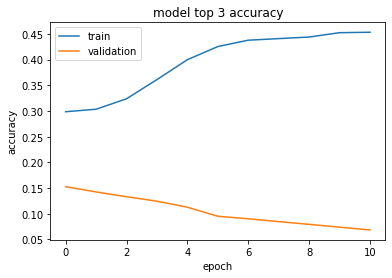

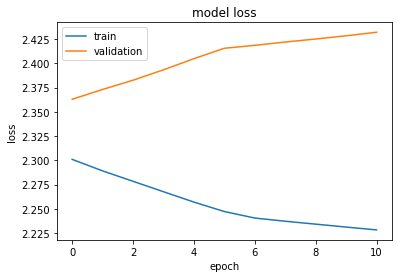

In [ ]:
# list all data in history
print(tabular_history.history.keys())
# summarize history for accuracy
plt.plot(tabular_history.history['top3_acc'])
plt.plot(tabular_history.history['val_top3_acc'])
plt.title('model top 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(tabular_history.history['loss'])
plt.plot(tabular_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

VERY POOR RESULTS!!!!! JUST FORGET ABOUT TABULAR DATA :\

### Prepare text and image data

#### Prepare text data

##### Prepare inputs
do this for both test and train datasets

In [ ]:
from tensorflow.keras import utils 

# Description_fa = 0 column in X
X_txt = X[:, 0].reshape(-1)
X_txt_test = X_test[['description_fa']].to_numpy().reshape(-1)

Y_txt  = Y

np.shape(X_txt), np.shape(Y_txt), np.shape(X_txt_test)

((23530,), (23530, 10), (1554,))

##### Text augmentation (SKIP THIS PART... TAKES TOO LONG)

upsampled duplicate texts are translated to one of 5 languages and then translated back to persian :D 

In [ ]:
from deep_translator import GoogleTranslator
from tqdm import tqdm
import time 

already_seen = []
choice = 0

for i, text in tqdm(enumerate(X_txt)):
    if text in already_seen:

      for attempt in range(10):
        try:
            if choice==0:
                choice += 1
                translated = GoogleTranslator(source='persian', target='english').translate(text)
                X_txt[i] = GoogleTranslator(source='english', target='persian').translate(translated)
            if choice==1:
                choice += 1
                translated = GoogleTranslator(source='persian', target='german').translate(text)
                X_txt[i] = GoogleTranslator(source='german', target='persian').translate(translated)
            if choice==2:
                choice += 1
                translated = GoogleTranslator(source='persian', target='russian').translate(text)
                X_txt[i] = GoogleTranslator(source='russian', target='persian').translate(translated)
            if choice==3:
                choice += 1
                translated = GoogleTranslator(source='persian', target='french').translate(text)
                X_txt[i] = GoogleTranslator(source='french', target='persian').translate(translated)
            if choice==4:
                choice += 1
                translated = GoogleTranslator(source='persian', target='arabic').translate(text)
                X_txt[i] = GoogleTranslator(source='arabic', target='persian').translate(translated)
            if choice==5:
                choice = 0
                translated = GoogleTranslator(source='persian', target='chinese').translate(text)
                X_txt[i] = GoogleTranslator(source='chinese', target='persian').translate(translated)
            break
        except:
            print('failed, retrying...')
            time.sleep(0.1)
            continue

    already_seen.append(text)


##### Set preprocessing up
Text data is normalized, word-tokenized, it's punctuations are deleted, stopwords are deleted, and it is lemmatized

In [ ]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
        temp = t
        for p in puncs:
            temp = temp.replace(p, '')
        tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

##### Apply preprocessing to data

In [ ]:
# train
train_docs = np.empty_like(X_txt)
for index, document in enumerate(X_txt):
    train_docs[index] = clean_doc(document)

In [ ]:
# test 
test_docs = np.empty_like(X_txt_test)
for index, document in enumerate(X_txt_test):
    test_docs[index] = clean_doc(document)

In [ ]:
train_docs[0]

'نیش همسر فرزند خردسال یک سروان نیرو انتظامی که افسر تجسس #است باعث اعدام یک قاچاقچی شده جلو چشمان او سوار بر اتومبیل بین دو تریلی ماند#مان له شد#شو او برای به دام انداختن مسبب این واقعه نقشه طراح کرد#کن'

##### Setting tokenizer up

In [ ]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fit the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [ ]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])
max_length

2367

##### Embed training sentences

In [ ]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
txt_x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
txt_x_train_padded, np.shape(txt_x_train_padded)

(array([[  84,  173, 1993, ...,    0,    0,    0],
        [1450, 1366,   20, ...,    0,    0,    0],
        [ 626, 1553,  290, ...,    0,    0,    0],
        ...,
        [ 778,   63,   57, ...,    0,    0,    0],
        [ 329, 1128, 1014, ...,    0,    0,    0],
        [ 359,  667,  359, ...,    0,    0,    0]], dtype=int32),
 (23530, 2367))

In [ ]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)
vocab_size

22967

##### Embed test sentences

In [ ]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
txt_x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
txt_x_test_padded, np.shape(txt_x_test_padded)

(array([[   0,    0,    0, ...,    0,    0,    0],
        [  99,    2,  925, ...,    0,    0,    0],
        [ 390,  467,   32, ...,    0,    0,    0],
        ...,
        [1663, 1827,  267, ...,    0,    0,    0],
        [  17, 1263,   76, ...,    0,    0,    0],
        [  94,   70,  525, ...,    0,    0,    0]], dtype=int32), (1554, 2367))

#### Creating TFRECORD dataset for text and image

###### Helper function for image augmentation

In [ ]:

def elastic_transform(image, alpha=1000, sigma=30, spline_order=1, mode='nearest', random_state=np.random):
    assert image.ndim == 3
    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    for i in range(image.shape[2]):
        result[:, :, i] = map_coordinates(
            image[:, :, i], indices, order=spline_order, mode=mode).reshape(shape)
    return result 


##### Train and validation TFRECORD writer

In [ ]:
writer = './drive/MyDrive/Bazzar/merged_dataset_train.tfrecords'
val_writer = './drive/MyDrive/Bazzar/merged_dataset_val.tfrecords'

train_image_root = './drive/MyDrive/Bazzar/train_set/'


writer = tf.io.TFRecordWriter(writer)
val_writer = tf.io.TFRecordWriter(val_writer)

val_split = 0.2



# 5th column holds Image names in X 
images = X[:, 5]
IM_SHAPE = [224, 224]

def int64_feature(_value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[_value]))

def bytes_feature(_value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[_value]))

choice = 0

##### Creating TFRECORD 

Upsampled images are augmented before being written:

They are either passed through elastic transformation, rotated, added with contrast or brightness


In [ ]:
written_images = []

# This array keeps track of whether we have saved that image before or not
# In case of duplicate image, we augment it :D
already_seen = []

val_size = 0
train_size = 0

from tqdm import tqdm

for im_name, im_text, im_genre in tqdm(zip(images, txt_x_train_padded, Y)):
    
    ##### FIIIIIXXXXXX
    im = plt.imread(os.path.join(train_image_root, im_name))
    im = resize(im, IM_SHAPE, anti_aliasing=True)
    
    if im.ndim != 3:
      continue

    #Image normalization
    mean = np.mean(im)
    std = np.std(im)
    im = (im - mean) / std

    # Keep written image names in track in case of duplicate image -> augment the duplicate image instead of feeding it again
    #if im_name not in written_images.append(im_name):
    if im_name not in already_seen:

      already_seen.append(im_name)

      example = tf.train.Example(
          features=tf.train.Features(
              feature={
                  'image': bytes_feature(im.astype(np.float32).tostring()),
                  'text': bytes_feature(im_text.astype(np.int64).tostring()),
                  'label': bytes_feature(im_genre.astype(np.int64).tostring()),
              }
      ))
      #Write to validation or train file
      if np.random.random() > val_split:
          writer.write(example.SerializeToString())
          train_size += 1
      else :
          val_writer.write(example.SerializeToString())
          val_size += 1
        

    # Augment duplicate image
    else:
        if choice == 0:
            im = elastic_transform(im)
            choice += 1
        elif choice== 1:
            im = rotate(im, angle=90)
            choice += 1
        elif choice== 2:
            im = rotate(im, angle=270)
            choice += 1
        elif choice== 3:
            # Add brightness
            im = im + (100/255)
            choice += 1
        elif choice== 4:
            # Add contrast
            im = im * 1.5
            choice = 0
            
        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'image': bytes_feature(im.astype(np.float32).tostring()),
                    'text': bytes_feature(im_text.astype(np.int64).tostring()),
                    'label': bytes_feature(im_genre.astype(np.int64).tostring()),
                }
            ))
        #Write to validation or train file
        if np.random.random() > val_split:
            writer.write(example.SerializeToString())
            train_size += 1
        else :
            val_writer.write(example.SerializeToString())
            val_size += 1


writer.close()
val_writer.close()

print("Success...")
print("Train dataset size : ", train_size)
print("Validation dataset size : ", val_size)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
11000it [1:17:51,  2.19it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
23530it [1:28:07,  4.45it/s]

Success...
Train dataset size :  18659
Validation dataset size :  4792


##### Test TFRECORD Writer

In [ ]:
writer = './drive/MyDrive/Bazzar/merged_dataset_test.tfrecords'
test_image_root = './drive/MyDrive/Bazzar/eval_set/'

writer = tf.io.TFRecordWriter(writer)

images = X_test['image'].to_numpy()

In [ ]:
written_images = []

test_size = 0

for im_name, im_text in tqdm(zip(images, txt_x_test_padded)):
    
    ##### FIIIIIXXXXXX
    im = plt.imread(os.path.join(test_image_root, im_name))
    im = resize(im, IM_SHAPE, anti_aliasing=True)

    #Image normalization
    mean = np.mean(im)
    std = np.std(im)
    im = (im - mean) / std
    
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': bytes_feature(im.astype(np.float32).tostring()),
                'text': bytes_feature(im_text.astype(np.int64).tostring())
            }
        ))
    test_size += 1
    writer.write(example.SerializeToString())
    
writer.close()

print("Success...")
print("Test dataset size: " + str(test_size))

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
1554it [17:57,  1.44it/s]

Success...
Test dataset size: 1554


#### Read text of TFRECORD dataset

In [ ]:
batch_size = 128
train_size = 10000


# This is the funciton used to decode the TFRecords
def _parse_function_train(proto):
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                       'text': tf.io.FixedLenFeature([], tf.string),
                       'label': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_raw(parsed_features['image'], tf.float32)
    image = tf.reshape(image, (IM_SHAPE[0], IM_SHAPE[1], 3))  
    text = tf.io.decode_raw(parsed_features['text'], tf.int64)
    text = tf.reshape(text, (2367, 1))  
    label = tf.io.decode_raw(parsed_features['label'], tf.int64)
    label = tf.reshape(label, (10, 1))  
    return text, label

def _parse_function_test(proto):
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                       'text': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_raw(parsed_features['image'], tf.float32)
    image = tf.reshape(image, (IM_SHAPE[0], IM_SHAPE[1], 3))  
    text = tf.io.decode_raw(parsed_features['text'], tf.int64)
    text = tf.reshape(text, (2367, 1))  
    return text
    
# Create dataset by parser
def create_dataset_train(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.shuffle(buffer_size=4000, seed=int(time.time()))
    dataset = dataset.map(_parse_function_train)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

def create_dataset_test(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(_parse_function_test)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

train_records = './drive/MyDrive/Bazzar/merged_dataset_train.tfrecords'
val_records = './drive/MyDrive/Bazzar/merged_dataset_val.tfrecords'
test_records = './drive/MyDrive/Bazzar/merged_dataset_test.tfrecords'
     
# Train and validation and test tensors
train_dataset = create_dataset_train(train_records)
val_dataset = create_dataset_train(val_records)
test_dataset = create_dataset_test(test_records)
 

##### Test if train dataset is valid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[365]
 [  0]
 [  0]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[ 2]
 [ 9]
 [48]
 ...
 [ 0]
 [ 0]
 [ 0]]
(224, 224, 3)
[[382]
 [  1]
 [921]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[128]
 [128]
 [ 17]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[1203]
 [   6]
 [  70]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[558]
 [  2]
 [  9]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[339]
 [933]
 [ 72]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[1111]
 [ 982]
 [ 306]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[  1]
 [351]
 [303]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[48]
 [ 0]
 [ 0]
 ...
 [ 0]
 [ 0]
 [ 0]]
(224, 224, 3)
[[ 288]
 [1800]
 [ 288]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[1360]
 [   0]
 [   0]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[596]
 [954]
 [200]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[397]
 [211]
 [  0]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[  2]
 [111]
 [293]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[1711]
 [   7]
 [   3]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[92]
 [55]
 [17]
 ...
 [ 0]
 [ 0]
 [ 0]]
(224, 224, 3)
[[217]
 [142]
 [  1]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[136]
 [ 65]
 [463]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[1908]
 [ 933]
 [   0]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[1623]
 [   1]
 [ 323]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[   6]
 [1503]
 [1159]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[ 9]
 [ 2]
 [99]
 ...
 [ 0]
 [ 0]
 [ 0]]
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 249]
 [1135]
 [   6]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
(224, 224, 3)
[[  1]
 [648]
 [751]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[172]
 [  4]
 [132]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[1368]
 [  24]
 [   9]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[689]
 [ 65]
 [504]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[1334]
 [   0]
 [   0]
 ...
 [   0]
 [   0]
 [   0]]
(224, 224, 3)
[[942]
 [  9]
 [942]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)
[[  4]
 [  1]
 [589]
 ...
 [  0]
 [  0]
 [  0]]
(224, 224, 3)


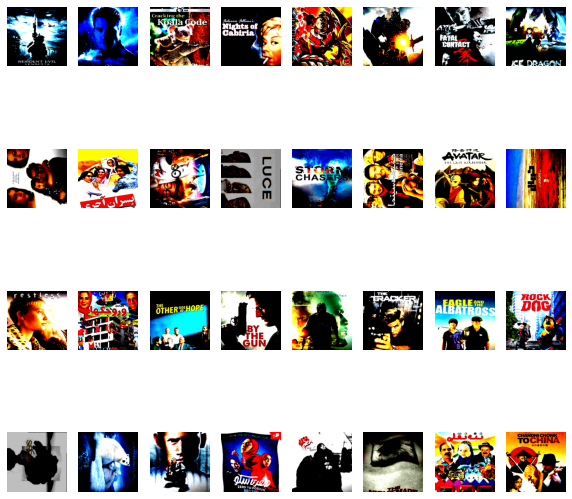

In [ ]:
image_batch, text_batch, label_batch = next(iter(val_dataset))
    
def show_batch(image_batch, text_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(32):
        ax = plt.subplot(4, 8, n + 1)
        plt.imshow(image_batch[n])
        #print(label_batch[n])
        print(text_batch[n])
        print(image_batch[n].shape)
        plt.axis("off")

show_batch(image_batch.numpy(),text_batch.numpy(), label_batch.numpy())

### Text Model 

The model is a sequential CNN with 3 maxpooling layers

In [ ]:
txt_model = Sequential()
txt_model.add(Embedding(vocab_size, 300, input_length=max_length))
txt_model.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
txt_model.add(MaxPooling1D(pool_size=2))
txt_model.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
txt_model.add(MaxPooling1D(pool_size=2))
txt_model.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
txt_model.add(GlobalMaxPooling1D())
txt_model.add(Dropout(0.1))
txt_model.add(Dense(500, activation="sigmoid"))
txt_model.add(Dense(10, activation='softmax'))

##### Compiling model

In [ ]:

top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

txt_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy, top3_acc])

txt_model.summary()
batch_size = 128
epochs = 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2367, 300)         6890100   
_________________________________________________________________
conv1d (Conv1D)              (None, 2367, 64)          76864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1183, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1183, 64)          32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 591, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 591, 64)           65600     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0

##### Training text model

In [ ]:

train_size = 18717
val_size =  4725

STEP_SIZE_TRAIN=train_size//batch_size
STEP_SIZE_VALID=(val_size)//batch_size


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

txt_checkpoint = ModelCheckpoint(filepath='./drive/MyDrive/Bazzar/txt_model.h5', 
                            verbose=1, save_best_only=True) #Save the whole model

early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True
)

callback = [txt_checkpoint, lr_reducer, early_stopping_cb]

start = datetime.now()

txt_history = txt_model.fit(train_dataset, steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, batch_size=batch_size, validation_data=val_dataset, epochs=epochs, callbacks = callback, shuffle=True)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
146/146 [==============================] - 547s 3s/step - loss: 2.1464 - categorical_accuracy: 0.2268 - top3_acc: 0.5021 - val_loss: 2.3723 - val_categorical_accuracy: 0.1890 - val_top3_acc: 0.4358

Epoch 00001: val_loss improved from inf to 2.37233, saving model to ./drive/MyDrive/Bazzar/txt_model.h5
Epoch 2/20
146/146 [==============================] - 533s 3s/step - loss: 1.9064 - categorical_accuracy: 0.3156 - top3_acc: 0.6176 - val_loss: 2.1258 - val_categorical_accuracy: 0.2799 - val_top3_acc: 0.5968

Epoch 00002: val_loss improved from 2.37233 to 2.12577, saving model to ./drive/MyDrive/Bazzar/txt_model.h5
Epoch 3/20
146/146 [==============================] - 542s 3s/step - loss: 1.6704 - categorical_accuracy: 0.3971 - top3_acc: 0.7256 - val_loss: 1.8519 - val_categorical_accuracy: 0.3947 - val_top3_acc: 0.6973

Epoch 00003: val_loss improved from 2.12577 to 1.85188, saving model to ./drive/MyDrive/Bazzar/txt_model.h5
Epoch 4/20
146/146 [==============================

##### Train results

dict_keys(['loss', 'categorical_accuracy', 'top3_acc', 'val_loss', 'val_categorical_accuracy', 'val_top3_acc', 'lr'])


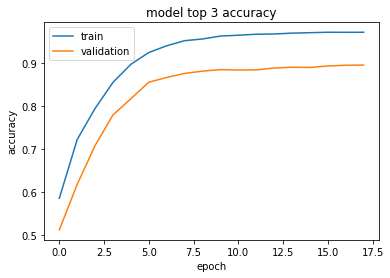

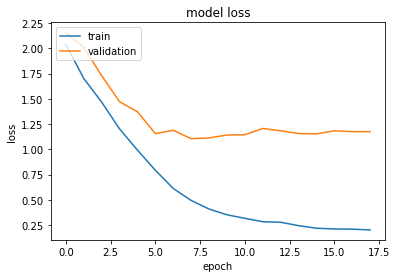

In [ ]:
# list all data in history
print(txt_history.history.keys())
# summarize history for accuracy
plt.plot(txt_history.history['top3_acc'])
plt.plot(txt_history.history['val_top3_acc'])
plt.title('model top 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(txt_history.history['loss'])
plt.plot(txt_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Read Image of TFRECORD dataset

In [ ]:
batch_size = 128
IM_SHAPE=[224,224]

train_size = 18717
val_size =  4725

# This is the funciton used to decode the TFRecords
def _parse_function_train(proto):
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                       'text': tf.io.FixedLenFeature([], tf.string),
                       'label': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_raw(parsed_features['image'], tf.float32)
    image = tf.reshape(image, (IM_SHAPE[0], IM_SHAPE[1], 3))  
    text = tf.io.decode_raw(parsed_features['text'], tf.int64)
    text = tf.reshape(text, (2367, 1))  
    label = tf.io.decode_raw(parsed_features['label'], tf.int64)
    label = tf.reshape(label, (10, 1))  
    return image, label

def _parse_function_test(proto):
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                       'text': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_raw(parsed_features['image'], tf.float32)
    image = tf.reshape(image, (IM_SHAPE[0], IM_SHAPE[1], 3))  
    text = tf.io.decode_raw(parsed_features['text'], tf.int64)
    text = tf.reshape(text, (2367, 1))  
    return image
    
# Create dataset by parser
def create_dataset_train(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.shuffle(buffer_size=4000, seed=int(time.time()))
    dataset = dataset.map(_parse_function_train)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

def create_dataset_test(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(_parse_function_test)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

train_records = './drive/MyDrive/Bazzar/merged_dataset_train.tfrecords'
val_records = './drive/MyDrive/Bazzar/merged_dataset_val.tfrecords'
test_records = './drive/MyDrive/Bazzar/merged_dataset_test.tfrecords'
     
# Train and validation and test tensors
train_dataset = create_dataset_train(train_records)
val_dataset = create_dataset_train(val_records)
test_dataset = create_dataset_test(test_records)
 

### Image model

The model is a pretrained VGG16 trained on Imagenet. The Convolutional layers are frozen and the fully connected layers are discarded, and instead a dense layer (500 neurons) is added to last layer and is trained.

In [ ]:

IMAGE_SIZE = [224, 224, 3]
#VGG Pretrained model
vgg = VGG16(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet', include_top=False)
#don't train existing weights (Transfer Learning)
for layer in vgg.layers:
    layer.trainable = False
print(vgg.output)
#Flatten the vgg lower layer output 
x = Flatten()(vgg.output)
#Trainable dense layer and softmax
x = Dense(500)(x)
prediction = Dense(10, activation='softmax')(x)

#Create model
image_model = Model(inputs=vgg.input, outputs=prediction)
#Compile model: Loss and Optimizer set



top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

image_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                     metrics=[keras.metrics.categorical_accuracy, top3_acc])
image_model.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)      

In [ ]:

train_size = 18717
val_size =  4725

STEP_SIZE_TRAIN=train_size//batch_size
STEP_SIZE_VALID=val_size//batch_size

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath='./drive/MyDrive/Bazzar/image_model.h5', 
                            verbose=1, save_best_only=True, ) #Save weights only

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

callbacks = [checkpoint, lr_reducer, early_stopping_cb]
start = datetime.now()

history = image_model.fit(train_dataset,
                    steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, 
                    epochs = 18, verbose=1, 
                    callbacks = callbacks,
                    validation_data = val_dataset, 
                    use_multiprocessing=True,
                    workers=4
                    )
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/18
146/146 [==============================] - 523s 3s/step - loss: 18.0937 - categorical_accuracy: 0.2608 - top3_acc: 0.5207 - val_loss: 4.0156 - val_categorical_accuracy: 0.4041 - val_top3_acc: 0.6751

Epoch 00001: val_loss improved from inf to 4.01557, saving model to ./drive/MyDrive/Bazzar/image_model.h5
Epoch 2/18
146/146 [==============================] - 691s 4s/step - loss: 1.7871 - categorical_accuracy: 0.6338 - top3_acc: 0.8726 - val_loss: 3.0508 - val_categorical_accuracy: 0.5080 - val_top3_acc: 0.7405

Epoch 00002: val_loss improved from 4.01557 to 3.05079, saving model to ./drive/MyDrive/Bazzar/image_model.h5
Epoch 3/18
146/146 [==============================] - 610s 4s/step - loss: 0.9582 - categorical_accuracy: 0.7645 - top3_acc: 0.9443 - val_loss: 3.1607 - val_categorical_accuracy: 0.5423 - val_top3_acc: 0.7546

Epoch 00003: val_loss did not improve from 3.05079
Epoch 4/18
146/146 [==============================] - 616s 4s/step - loss: 0.6210 - categorical_accura

dict_keys(['loss', 'categorical_accuracy', 'top3_acc', 'val_loss', 'val_categorical_accuracy', 'val_top3_acc', 'lr'])


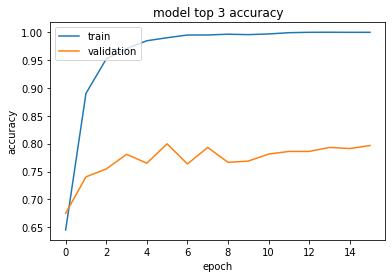

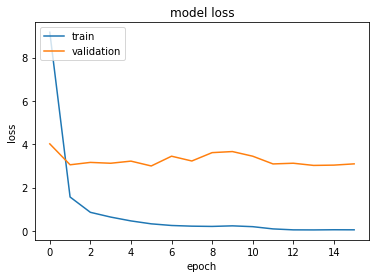

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['top3_acc'])
plt.plot(history.history['val_top3_acc'])
plt.title('model top 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Read both Image and Text in TFRECORD dataset 

In [8]:
batch_size = 128
IM_SHAPE=[224,224]


train_size = 18717
val_size =  4725
STEP_SIZE_TRAIN=train_size//batch_size
STEP_SIZE_VALID=val_size//batch_size

import time

# This is the funciton used to decode the TFRecords
def _parse_function_train(proto):
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                       'text': tf.io.FixedLenFeature([], tf.string),
                       'label': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_raw(parsed_features['image'], tf.float32)
    image = tf.reshape(image, (IM_SHAPE[0], IM_SHAPE[1], 3))  
    text = tf.io.decode_raw(parsed_features['text'], tf.int64)
    text = tf.reshape(text, (2367, 1))  
    label = tf.io.decode_raw(parsed_features['label'], tf.int64)
    label = tf.reshape(label, (10, 1))  
    return (image, text), label

def _parse_function_test(proto):
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                       'text': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_raw(parsed_features['image'], tf.float32)
    image = tf.reshape(image, (IM_SHAPE[0], IM_SHAPE[1], 3))  
    text = tf.io.decode_raw(parsed_features['text'], tf.int64)
    text = tf.reshape(text, (2367, 1))  
    return (image, text)
    
# Create dataset by parser
def create_dataset_train(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.shuffle(buffer_size=4000, seed=int(time.time()))
    dataset = dataset.map(_parse_function_train)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

def create_dataset_test(files):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(_parse_function_test)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

train_records = './drive/MyDrive/Bazzar/merged_dataset_train.tfrecords'
val_records = './drive/MyDrive/Bazzar/merged_dataset_val.tfrecords'
test_records = './drive/MyDrive/Bazzar/merged_dataset_test.tfrecords'
     
# Train and validation and test tensors
train_dataset = create_dataset_train(train_records)
val_dataset = create_dataset_train(val_records)
test_dataset = create_dataset_test(test_records)
 

### Merged model (Final model)

##### Reconstruct Image and text Models

In [ ]:
# Reconstructing models

dependencies = {
    'top3_acc': top3_acc}

reconstructed_txt_model = load_model("./drive/MyDrive/Bazzar/txt_model.h5", custom_objects = dependencies)
#txt_history = reconstructed_txt_model.evaluate(val_dataset,  steps = STEP_SIZE_VALID)

reconstructed_image_model = load_model("./drive/MyDrive/Bazzar/image_model.h5", custom_objects = dependencies )
#txt_history = reconstructed_txt_model.evaluate(txt_x_train_padded, Y_txt)

##### Create merged model

The previous trained text and image models are frozen and the output of their 500 neuron dense layer (Right before their softmax) is concatenated together and passed through 2 dense layers. We will train these newly created dense layers

In [ ]:

for layer in reconstructed_image_model.layers:
    layer.trainable = False

for layer in reconstructed_txt_model.layers:
    layer.trainable = False

from keras.layers import concatenate, Dropout, Flatten

image_out = Flatten()(reconstructed_image_model.layers[-2].output)
text_out = Flatten()(reconstructed_txt_model.layers[-2].output)
merged_layers = concatenate([image_out, text_out])

x = BatchNormalization()(merged_layers)
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(100, activation='relu')(x)
output = Dense(10,activation="softmax")(x)

merged_model = Model([reconstructed_image_model.input, reconstructed_txt_model.input], output)



top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

merged_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy, top3_acc])

merged_model.summary()


##### Train 

In [ ]:
batch_size = 128
epochs = 20

train_size = 18717
val_size =  4725

STEP_SIZE_TRAIN=train_size//batch_size
STEP_SIZE_VALID=val_size//batch_size


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

txt_checkpoint = ModelCheckpoint(filepath='./drive/MyDrive/Bazzar/merged_model.h5', 
                            verbose=1, save_best_only=True) #Save the whole model

early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True
)

callback = [txt_checkpoint, lr_reducer, early_stopping_cb]

start = datetime.now()

merged_history = merged_model.fit(train_dataset,
                    steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, 
                    epochs = 18, verbose=1, 
                    callbacks = callbacks,
                    validation_data = val_dataset, 
                    use_multiprocessing=True,
                    workers=4
                    )



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/18
146/146 [==============================] - 586s 3s/step - loss: 1.7674 - categorical_accuracy: 0.4036 - top3_acc: 0.6854 - val_loss: 1.6724 - val_categorical_accuracy: 0.4592 - val_top3_acc: 0.7897

Epoch 00001: val_loss improved from inf to 1.67240, saving model to ./drive/MyDrive/Bazzar/merged_model.h5
Epoch 2/18
146/146 [==============================] - 506s 3s/step - loss: 1.4900 - categorical_accuracy: 0.5103 - top3_acc: 0.7821 - val_loss: 1.5519 - val_categorical_accuracy: 0.4829 - val_top3_acc: 0.8047

Epoch 00002: val_loss improved from 1.67240 to 1.55187, saving model to ./drive/MyDrive/Bazzar/merged_model.h5
Epoch 3/18
146/146 [==============================] - 506s 3s/step - loss: 1.4346 - categorical_accuracy: 0.5230 - top3_acc: 0.8003 - val_loss: 1.5063 - val_categorical_accuracy: 0.4978 - val_top3_acc: 0.8082

Epoch 00003: val_loss improved from 1.55187 to 1.50629, saving model to ./drive/MyDrive/Bazzar/merged_model.h5
Epoch 4/18
146/146 [=====================

##### Training results

 Training is not complete and we probably would have better results with more epochs but due to time constraints lets go with it :(

dict_keys(['loss', 'categorical_accuracy', 'top3_acc', 'val_loss', 'val_categorical_accuracy', 'val_top3_acc', 'lr'])


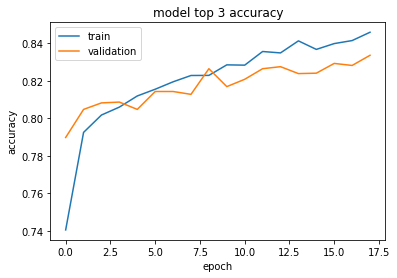

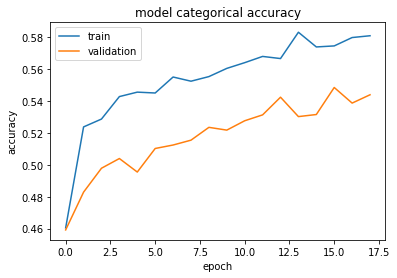

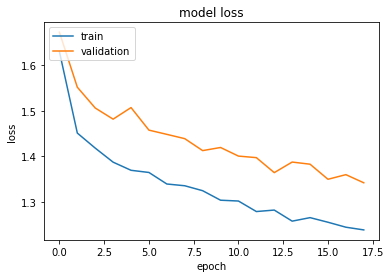

In [11]:
# list all data in history
print(merged_history.history.keys())
# summarize history for top 3 accuracy
plt.plot(merged_history.history['top3_acc'])
plt.plot(merged_history.history['val_top3_acc'])
plt.title('model top 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for categorical accuracy
plt.plot(merged_history.history['categorical_accuracy'])
plt.plot(merged_history.history['val_categorical_accuracy'])
plt.title('model categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(merged_history.history['loss'])
plt.plot(merged_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting Test Dataset

##### Reconstruct merged model

In [5]:

top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

dependencies = {
    'top3_acc': top3_acc}

reconstructed_merged_model = load_model("./drive/MyDrive/Bazzar/merged_model.h5", custom_objects = dependencies)

##### Save prediction probabilities and predicted labels

In [74]:
test_size = 1554
batch_size = 128
STEP_SIZE_TEST =test_size//batch_size + 1

# Save prediction probabilities results in Prediction probs array
prediction_probs = []

for i in range(STEP_SIZE_TEST):
  image_batch, text_batch = next(iter(test_dataset))
  prediction = reconstructed_merged_model.predict((image_batch, text_batch), batch_size= batch_size )
  if i == 0:
    prediction_probs = prediction
  else:
    prediction_probs = np.append(prediction_probs, prediction, axis = 0)

predicions = prediction_probs.argmax(axis=1)

print(prediction_probs.shape)
print(predicions.shape)

(1664, 10)
(1664,)


##### Save prediction results in a table in CSV format

In [78]:
Result = pd.DataFrame(list(zip(prediction_probs[:1554], predicions[:1554], label_transformer.inverse_transform(predicions[:1554]))), columns=['Prediction Probabilities', 'Predictions(Encoded)', 'predictions'])
Result.to_csv('./RESULTS.CSV')

In [79]:
Result.head()

,Prediction Probabilities,Predictions(Encoded),predictions
0,"[0.04447925, 0.046766553, 0.006193739, 0.00812...",9,thriller
1,"[0.0009733607, 0.33437473, 0.3772161, 0.088761...",2,animation
2,"[0.07876411, 0.035666827, 0.042429082, 0.53891...",3,comedy
3,"[0.009249125, 0.15258285, 0.07845397, 0.424863...",3,comedy
4,"[0.0700583, 0.1272029, 0.051589645, 0.03739968...",9,thriller


#THANK YOU FOR YOUR TIME